# Network Intrusion Detection System using AI

Ce notebook construit un syst√®me de d√©tection d'intrusion r√©seau √† double couche :
- **D√©tection par signature** (Random Forest, SVM, k-NN, MLP)
- **D√©tection d'anomalies** (Isolation Forest)

Le dataset utilis√© est UNSW-NB15.

## 1. Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import logging
import warnings
import time
import winsound
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

# Supprimer les avertissements non n√©cessaires
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Cr√©ation des dossiers pour les r√©sultats
os.makedirs('figures/knn_improved', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Configure logging for the classifier class
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Cr√©ation des dossiers pour les r√©sultats
os.makedirs('figures/mlp', exist_ok=True)

## 2. Data Loading and Exploration

In [4]:
# Load the dataset
df = pd.read_csv("UNSW_NB15_training-set.csv")

# Display basic information
print("Dataset preview:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nClass distribution (label):")
print(df['label'].value_counts())
print("\nAttack categories (attack_cat):")
print(df['attack_cat'].value_counts())

Dataset preview:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2          

## 3. Data Visualization

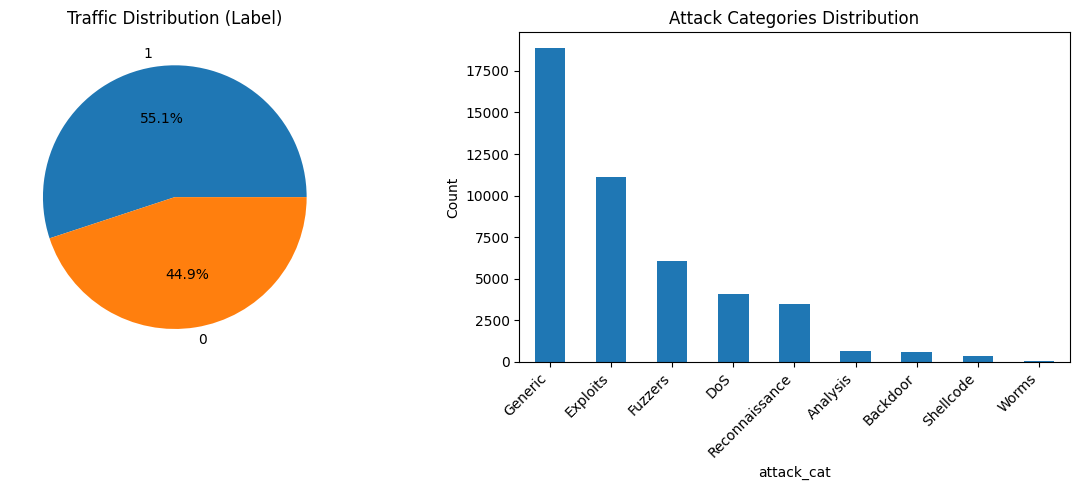

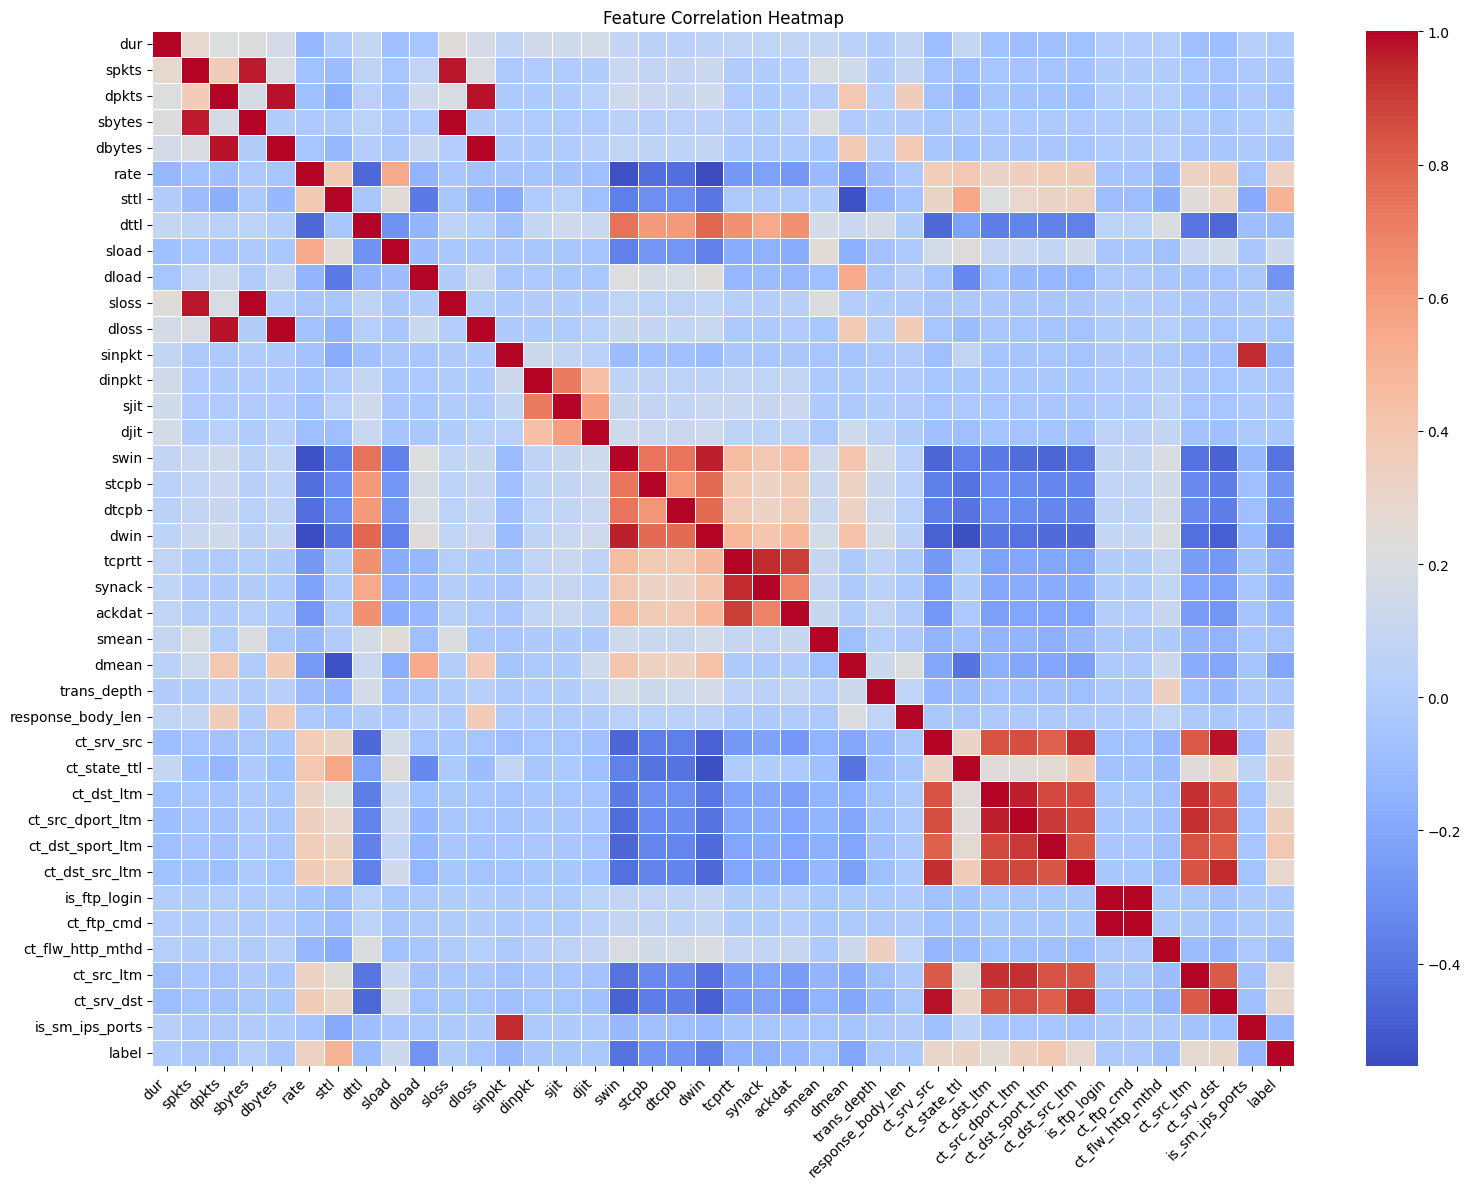

In [5]:
# Plot class distribution and attack categories
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1)
ax1.set_title('Traffic Distribution (Label)')
ax1.set_ylabel('')

ax2 = plt.subplot(1, 2, 2)
attack_data = df[df['label'] == 1]['attack_cat'].value_counts()
attack_data.plot(kind='bar', ax=ax2)
ax2.set_title('Attack Categories Distribution')
ax2.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlation heatmap of numeric features (excluding 'id')
plt.figure(figsize=(16, 12))
numeric_cols = df.select_dtypes(include=np.number).columns.drop('id', errors='ignore')
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Entra√Ænement KNN 

### Explication de la Fonction `load_and_preprocess_data`

La fonction `load_and_preprocess_data` est con√ßue pour charger les donn√©es √† partir d'un fichier CSV, les pr√©traiter et les diviser en ensembles d'entra√Ænement, de validation et de test. Voici une explication d√©taill√©e de chaque √©tape :

1.  **Chargement des donn√©es :**
    *   La fonction prend en entr√©e le chemin du fichier CSV (`filepath`).
    *   Elle utilise `pd.read_csv` pour charger les donn√©es dans un DataFrame pandas.
    *   Des v√©rifications sont effectu√©es pour s'assurer que le fichier existe et que les colonnes obligatoires (`label`) sont pr√©sentes.

2.  **Suppression des colonnes non n√©cessaires :**
    *   Les colonnes `id` et `attack_cat` sont supprim√©es car elles ne sont pas n√©cessaires pour la classification binaire (Attaque/Normal).

3.  **Gestion des valeurs manquantes :**
    *   La fonction v√©rifie s'il y a des valeurs manquantes dans le DataFrame.
    *   Si des valeurs manquantes sont d√©tect√©es, les lignes correspondantes sont supprim√©es.

4.  **S√©paration des caract√©ristiques et des √©tiquettes :**
    *   La colonne `label` est s√©par√©e du reste des donn√©es pour cr√©er les ensembles de caract√©ristiques (X) et d'√©tiquettes (y).

5.  **Encodage des caract√©ristiques cat√©gorielles :**
    *   Les colonnes cat√©gorielles (de type `object` ou `category`) sont encod√©es en utilisant `LabelEncoder`.
    *   Un `LabelEncoder` est cr√©√© pour chaque colonne cat√©gorielle et stock√© dans un dictionnaire (`label_encoders`) pour une utilisation ult√©rieure.

6.  **Mise √† l'√©chelle des caract√©ristiques num√©riques :**
    *   Les caract√©ristiques num√©riques sont mises √† l'√©chelle en utilisant `StandardScaler` pour avoir une moyenne de 0 et un √©cart type de 1.
    *   Le `StandardScaler` est stock√© pour une utilisation ult√©rieure.

7.  **Division en ensembles d'entra√Ænement, de validation et de test :**
    *   Les donn√©es sont divis√©es en ensembles d'entra√Ænement (70%), de validation (15%) et de test (15%) en utilisant `train_test_split`.
    *   La stratification est utilis√©e pour s'assurer que la distribution des classes est la m√™me dans chaque ensemble.

8.  **Retour des donn√©es pr√©trait√©es :**
    *   La fonction retourne les ensembles d'entra√Ænement, de validation et de test, ainsi que le `StandardScaler` et les `LabelEncoder` utilis√©s pour le pr√©traitement.

In [6]:

def load_and_preprocess_data(filepath, test_size=0.2, val_size=0.15, random_state=42):
    """
    Charge et pr√©traite les donn√©es pour l'entra√Ænement
    Args:
        filepath: Chemin du fichier CSV
        test_size: Proportion de l'ensemble de test
        val_size: Proportion de l'ensemble de validation
        random_state: Graine al√©atoire pour la reproductibilit√©
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoders
    """
    print(f"Chargement et pr√©traitement des donn√©es depuis {filepath}...")
    
    # V√©rifier l'existence du fichier
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Le fichier {filepath} n'existe pas.")
    
    # Charger les donn√©es avec gestion d'erreurs
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        raise Exception(f"Erreur lors du chargement du fichier CSV: {str(e)}")
    
    print(f"Donn√©es charg√©es: {df.shape[0]} lignes et {df.shape[1]} colonnes")
    
    # V√©rifier que les colonnes obligatoires sont pr√©sentes
    required_cols = ['label']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"Colonnes requises manquantes. Assurez-vous que {required_cols} sont pr√©sentes.")
    
    # Supprimer les colonnes non n√©cessaires
    df_processed = df.drop(columns=['id', 'attack_cat'], errors='ignore')
    
    # Afficher les informations sur les valeurs manquantes
    missing_values = df_processed.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if not missing_cols.empty:
        print(f"Valeurs manquantes d√©tect√©es dans les colonnes suivantes:")
        for col, count in missing_cols.items():
            print(f"  - {col}: {count} valeurs manquantes ({(count/len(df_processed))*100:.2f}%)")
    
    # G√©rer les valeurs manquantes - consid√©rer l'imputation plut√¥t que la suppression
    rows_before = df_processed.shape[0]
    df_processed = df_processed.dropna()
    rows_after = df_processed.shape[0]
    if rows_before > rows_after:
        print(f"Suppression de {rows_before - rows_after} lignes avec des valeurs manquantes ({(rows_before - rows_after) / rows_before * 100:.2f}%)")
    
    # S√©parer les caract√©ristiques et les √©tiquettes
    X = df_processed.drop(columns=['label'], errors='ignore')
    y = df_processed['label']  # 0 pour normal, 1 pour attaque
    
    # V√©rifier la distribution des classes
    class_counts = y.value_counts()
    print(f"Distribution des classes:")
    for cls, count in class_counts.items():
        print(f"  - Classe {cls}: {count} √©chantillons ({count/len(y)*100:.2f}%)")
    
    # Encoder les caract√©ristiques cat√©gorielles
    label_encoders = {}
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print(f"Encodage des {len(categorical_cols)} colonnes cat√©gorielles:")
        for col in categorical_cols:
            unique_values = X[col].nunique()
            print(f"  - {col}: {unique_values} valeurs uniques")
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))  # Convertir en string pour √©viter les erreurs
            label_encoders[col] = le
    
    # Mise √† l'√©chelle des caract√©ristiques num√©riques
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Division en ensembles d'entra√Ænement, validation et test avec stratification
    try:
        # D'abord, s√©parer les donn√©es de test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        # Ensuite, diviser les donn√©es restantes en ensembles d'entra√Ænement et de validation
        val_ratio = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
        )
    except ValueError as e:
        # Si la stratification √©choue (par exemple, trop peu d'√©chantillons dans une classe)
        print(f"Avertissement lors de la stratification: {str(e)}")
        print("Tentative de division sans stratification...")
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_scaled, y, test_size=test_size, random_state=random_state
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_ratio, random_state=random_state
        )
    
    print(f"Dimensions des ensembles de donn√©es:")
    print(f"  Train: X={X_train.shape}, y={y_train.shape}")
    print(f"  Validation: X={X_val.shape}, y={y_val.shape}")
    print(f"  Test: X={X_test.shape}, y={y_test.shape}")
    
    # V√©rifier les distributions des classes dans chaque ensemble
    print(f"Distribution des classes dans les ensembles:")
    print(f"  Train: {np.bincount(y_train.astype(int))}")
    print(f"  Validation: {np.bincount(y_val.astype(int))}")
    print(f"  Test: {np.bincount(y_test.astype(int))}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoders


### Explication de la Fonction `optimize_knn_hyperparameters`

La fonction `optimize_knn_hyperparameters` est con√ßue pour optimiser les hyperparam√®tres d'un mod√®le KNN (K-Nearest Neighbors) en utilisant une recherche al√©atoire sur une grille de param√®tres pr√©d√©finie. Voici une explication d√©taill√©e de chaque √©tape :

1.  **D√©finition de la grille de param√®tres :**
    *   Un dictionnaire `param_grid` est d√©fini, contenant les hyperparam√®tres √† optimiser et les valeurs possibles pour chacun d'eux.
        *   `n_neighbors`: Nombre de voisins √† consid√©rer (3, 5, 7, 9, 11, 15).
        *   `weights`: Pond√©ration des voisins (uniforme ou bas√©e sur la distance).
        *   `metric`: M√©trique de distance √† utiliser (euclidienne ou de Manhattan).
        *   `algorithm`: Algorithme utilis√© pour calculer les plus proches voisins ('auto', 'ball_tree', 'kd_tree').

2.  **Cr√©ation du mod√®le KNN :**
    *   Un mod√®le KNN est cr√©√© en utilisant la classe `KNeighborsClassifier` de scikit-learn.

3.  **Recherche par grille avec validation crois√©e :**
    *   La fonction utilise `RandomizedSearchCV` pour trouver les meilleurs hyperparam√®tres.
        *   `knn`: Le mod√®le KNN √† optimiser.
        *   `param_grid`: La grille de param√®tres √† explorer.
        *   `cv`: Le nombre de plis pour la validation crois√©e (par d√©faut 3).
        *   `scoring`: La m√©trique √† utiliser pour √©valuer les performances (accuracy).
        *   `n_jobs`: Le nombre de c≈ìurs de CPU √† utiliser en parall√®le (-1 pour utiliser tous les c≈ìurs disponibles).
        *   `verbose`: Niveau de verbosit√© (1 pour afficher des informations pendant la recherche).

4.  **Entra√Ænement du mod√®le :**
    *   La fonction entra√Æne le mod√®le en utilisant la m√©thode `fit` de `RandomizedSearchCV`.
    *   Le temps d'entra√Ænement est mesur√© pour √©valuer l'efficacit√© de la recherche.

5.  **√âvaluation sur l'ensemble de validation :**
    *   Une fois la recherche termin√©e, le mod√®le est √©valu√© sur l'ensemble de validation en utilisant la m√©thode `predict` pour obtenir les pr√©dictions, puis en calculant l'accuracy avec `accuracy_score`.

6.  **Affichage des r√©sultats :**
    *   Les meilleurs hyperparam√®tres trouv√©s sont affich√©s, ainsi que le score de validation crois√©e et le score sur l'ensemble de validation.
    *   Les 3 meilleures combinaisons de param√®tres sont √©galement affich√©es, avec leurs scores moyens et √©carts-types.

7.  **Gestion des erreurs :**
    *   Si une erreur se produit pendant l'optimisation, la fonction utilise des param√®tres par d√©faut pour cr√©er et entra√Æner un mod√®le KNN.

8.  **Retour des r√©sultats :**
    *   La fonction retourne les meilleurs hyperparam√®tres trouv√©s et le score de validation.


In [7]:

def optimize_knn_hyperparameters(X_train, y_train, X_val, y_val, cv=3):
    """
    Optimise les hyperparam√®tres du mod√®le KNN
    Args:
        X_train: Caract√©ristiques d'entra√Ænement
        y_train: √âtiquettes d'entra√Ænement
        X_val: Caract√©ristiques de validation
        y_val: √âtiquettes de validation
        cv: Nombre de plis pour la validation crois√©e
    Returns:
        Meilleurs hyperparam√®tres et score
    """
    print(f"Optimisation des hyperparam√®tres KNN...")
    
    # D√©finir une grille de param√®tres plus efficace
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
    
    # Cr√©er le mod√®le KNN
    knn = KNeighborsClassifier()
    
    # Utiliser GridSearchCV pour trouver les meilleurs hyperparam√®tres
    print(f"Lancement de la recherche par grille avec {cv} plis...")
    grid_search = RandomizedSearchCV(
        knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
    )
    
    try:
        # Entra√Æner le mod√®le avec gestion du temps
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        search_time = time.time() - start_time
        print(f"Recherche par grille termin√©e en {search_time:.2f} secondes")
        
        # √âvaluer sur l'ensemble de validation
        val_score = accuracy_score(y_val, grid_search.predict(X_val))
        print(f"Meilleurs hyperparam√®tres: {grid_search.best_params_}")
        print(f"Score de validation crois√©e: {grid_search.best_score_:.4f}")
        print(f"Score sur l'ensemble de validation: {val_score:.4f}")
        
        # Afficher les 3 meilleures combinaisons de param√®tres
        results = grid_search.cv_results_
        sorted_idx = np.argsort(results['mean_test_score'])[::-1]
        print("\nTop 3 des meilleures combinaisons de param√®tres:")
        for i in range(min(3, len(sorted_idx))):
            idx = sorted_idx[i]
            print(f"Rang {i+1}: {results['params'][idx]}")
            print(f"  Score moyen: {results['mean_test_score'][idx]:.4f}")
            print(f"  √âcart-type: {results['std_test_score'][idx]:.4f}")
        
        return grid_search.best_params_, val_score
    
    except Exception as e:
        print(f"Erreur lors de l'optimisation des hyperparam√®tres: {str(e)}")
        # Param√®tres par d√©faut en cas d'erreur
        default_params = {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}
        print(f"Utilisation des param√®tres par d√©faut: {default_params}")
        model = KNeighborsClassifier(**default_params)
        model.fit(X_train, y_train)
        val_score = accuracy_score(y_val, model.predict(X_val))
        return default_params, val_score


### Explication de la Fonction `plot_learning_curve`

La fonction `plot_learning_curve` est con√ßue pour √©valuer l'impact de la taille de l'ensemble d'entra√Ænement sur les performances du mod√®le KNN. Elle utilise la fonction `learning_curve` de scikit-learn pour g√©n√©rer des courbes d'apprentissage qui montrent comment l'accuracy du mod√®le √©volue en fonction de la taille de l'ensemble d'entra√Ænement. Voici une explication d√©taill√©e de chaque √©tape :

1.  **Pr√©paration du graphique :**
    *   La fonction prend en entr√©e un estimateur (le mod√®le KNN), les caract√©ristiques (X), les √©tiquettes (y), le nombre de plis pour la validation crois√©e (cv), le nombre de jobs pour le calcul parall√®le (n\_jobs) et les tailles relatives de l'ensemble d'entra√Ænement √† √©valuer (train\_sizes).
    *   Elle cr√©e une figure matplotlib pour afficher les courbes d'apprentissage.

2.  **G√©n√©ration des courbes d'apprentissage :**
    *   La fonction utilise la fonction `learning_curve` de scikit-learn pour g√©n√©rer les courbes d'apprentissage.
        *   `estimator`: Le mod√®le √† √©valuer.
        *   `X`: Les caract√©ristiques.
        *   `y`: Les √©tiquettes.
        *   `train_sizes`: Les tailles relatives de l'ensemble d'entra√Ænement √† √©valuer.
        *   `cv`: Le nombre de plis pour la validation crois√©e.
        *   `n_jobs`: Le nombre de jobs pour le calcul parall√®le.
        *   `scoring`: La m√©trique √† utiliser pour √©valuer les performances (accuracy).
        *   `shuffle`: M√©langer les donn√©es avant de les diviser en plis.
        *   `random_state`: Graine al√©atoire pour la reproductibilit√©.
    *   La fonction `learning_curve` retourne les tailles de l'ensemble d'entra√Ænement, les scores d'entra√Ænement et les scores de validation.

3.  **Calcul des moyennes et √©carts-types :**
    *   La fonction calcule les moyennes et les √©carts-types des scores d'entra√Ænement et de validation pour chaque taille d'ensemble d'entra√Ænement.

4.  **Tra√ßage des courbes d'apprentissage :**
    *   La fonction trace les courbes d'apprentissage en utilisant les moyennes et les √©carts-types calcul√©s.
    *   Elle utilise des couleurs et des styles diff√©rents pour les courbes d'entra√Ænement et de validation.
    *   Elle ajoute une zone ombr√©e autour de chaque courbe pour repr√©senter l'√©cart-type.

5.  **Am√©lioration de l'aspect du graphique :**
    *   La fonction ajoute un titre, des √©tiquettes d'axe, une grille et une l√©gende au graphique.
    *   Elle utilise des polices de caract√®res plus grandes et plus grasses pour am√©liorer la lisibilit√©.
    *   Elle ajuste la disposition du graphique pour √©viter les chevauchements.

6.  **Ajout d'informations importantes :**
    *   La fonction ajoute une annotation pour indiquer la taille de l'ensemble d'entra√Ænement qui donne la meilleure accuracy de validation.

7.  **Sauvegarde du graphique :**
    *   La fonction sauvegarde le graphique dans un fichier PNG.

8.  **Gestion des erreurs :**
    *   Si une erreur se produit pendant le tra√ßage des courbes d'apprentissage, la fonction affiche un message d'erreur et ferme la figure.



In [8]:

def plot_learning_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Trace la courbe d'apprentissage pour √©valuer l'impact de la taille de l'ensemble d'entra√Ænement
    Args:
        estimator: Le mod√®le √† √©valuer
        X: Caract√©ristiques
        y: √âtiquettes
        cv: Nombre de plis pour la validation crois√©e
        n_jobs: Nombre de jobs pour le calcul parall√®le
        train_sizes: Tailles relatives de l'ensemble d'entra√Ænement √† √©valuer
    """
    print("Tra√ßage de la courbe d'apprentissage...")
    plt.figure(figsize=(10, 6))
    
    try:
        train_sizes, train_scores, val_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=cv, n_jobs=n_jobs,
            scoring='accuracy', shuffle=True, random_state=42
        )
        
        # Calculer les moyennes et √©carts-types
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        # Tracer les courbes d'apprentissage avec un style am√©lior√©
        plt.plot(train_sizes, train_mean, 'o-', color='#1f77b4', label='Entra√Ænement', linewidth=2)
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#1f77b4')
        plt.plot(train_sizes, val_mean, 'o-', color='#ff7f0e', label='Validation', linewidth=2)
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#ff7f0e')
        
        # Am√©liorer l'aspect du graphique
        plt.title('Courbe d\'apprentissage KNN', fontsize=14, fontweight='bold')
        plt.xlabel('Taille de l\'ensemble d\'entra√Ænement', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(loc='lower right', fontsize=12)
        plt.tight_layout()
        
        # Ajouter des informations importantes
        max_val_mean = np.max(val_mean)
        max_val_idx = np.argmax(val_mean)
        max_val_size = train_sizes[max_val_idx]
        plt.annotate(f'Maximum: {max_val_mean:.4f}',
                    xy=(max_val_size, max_val_mean),
                    xytext=(max_val_size, max_val_mean - 0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                    fontsize=10, ha='center')
        
        plt.savefig('figures/knn_improved/knn_learning_curve.png', dpi=300, bbox_inches='tight')
        print("‚úÖ Courbe d'apprentissage enregistr√©e dans figures/knn_improved/knn_learning_curve.png")
        
    except Exception as e:
        print(f"Erreur lors du tra√ßage de la courbe d'apprentissage: {str(e)}")
        plt.close()




### Explication de la Fonction `plot_training_metrics`

La fonction `plot_training_metrics` est con√ßue pour visualiser les m√©triques d'entra√Ænement et de validation au fil des √©poques lors de l'entra√Ænement d'un mod√®le KNN. Elle prend en entr√©e les listes des accuracies, losses, F1-scores et recalls pour les ensembles d'entra√Ænement et de validation, ainsi que le nombre total d'√©poques. Voici une explication d√©taill√©e de chaque √©tape :

1.  **Configuration de la figure :**
    *   La fonction cr√©e une figure avec quatre sous-graphiques dispos√©s en une grille 2x2. Chaque sous-graphique affichera une m√©trique diff√©rente (accuracy, loss, F1-score, recall).
    *   La taille de la figure est d√©finie pour une meilleure lisibilit√©.

2.  **Style commun pour les graphiques :**
    *   Une boucle est utilis√©e pour appliquer un style commun √† tous les sous-graphiques :
        *   Ajout d'une grille en arri√®re-plan pour faciliter la lecture des valeurs.
        *   Placement de la grille derri√®re les donn√©es pour ne pas obstruer les courbes.

3.  **Tra√ßage des m√©triques :**
    *   Pour chaque m√©trique (accuracy, loss, F1-score, recall) :
        *   Les valeurs d'entra√Ænement et de validation sont trac√©es en fonction du nombre d'√©poques.
        *   Des couleurs et des √©tiquettes diff√©rentes sont utilis√©es pour distinguer les courbes d'entra√Ænement et de validation.
        *   Un titre est ajout√© pour identifier la m√©trique affich√©e.
        *   Des √©tiquettes sont ajout√©es pour les axes x et y.
        *   Une l√©gende est ajout√©e pour identifier les courbes.

4.  **Am√©lioration de la lisibilit√© :**
    *   La fonction utilise des polices de caract√®res plus grandes et plus grasses pour am√©liorer la lisibilit√© des titres et des √©tiquettes.
    *   Elle ajuste la disposition des sous-graphiques pour √©viter les chevauchements.

5.  **Sauvegarde de la figure :**
    *   La figure est sauvegard√©e dans un fichier PNG.

6.  **Retour de la figure :**
    *   La fonction retourne la figure matplotlib cr√©√©e, ce qui permet de la manipuler ou de la fermer ult√©rieurement si n√©cessaire.


In [9]:
def plot_training_metrics(
     train_accuracies, val_accuracies, train_losses, val_losses,
     train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
     algorithm_name="XGBoost", output_dir="figures/xgb"):
     """
     Fonction d√©di√©e pour tracer les m√©triques d'entra√Ænement et enregistrer chaque graphe dans un fichier s√©par√©.
     Args:
          train_accuracies: Liste des accuracies d'entra√Ænement
          val_accuracies: Liste des accuracies de validation
          train_losses: Liste des pertes d'entra√Ænement
          val_losses: Liste des pertes de validation
          train_f1s: Liste des F1 scores d'entra√Ænement
          val_f1s: Liste des F1 scores de validation
          train_recalls: Liste des recalls d'entra√Ænement
          val_recalls: Liste des recalls de validation
          n_epochs: Nombre d'√©poques
          algorithm_name: Nom de l'algorithme pour les titres (d√©faut: "XGBoost")
          output_dir: R√©pertoire de sortie pour les figures (d√©faut: "figures/xgb")
     Returns:
          None
     """
     # Style commun pour tous les graphiques
     metrics = {
          'Accuracy': (train_accuracies, val_accuracies),
          'Loss': (train_losses, val_losses),
          'F1 Score': (train_f1s, val_f1s),
          'Recall': (train_recalls, val_recalls)
     }

     for metric_name, (train_metric, val_metric) in metrics.items():
          fig, ax = plt.subplots(figsize=(10, 6))
          ax.grid(True, linestyle='--', alpha=0.7)
          ax.set_axisbelow(True)  # Placer la grille derri√®re les donn√©es

          # Graphique de la m√©trique
          ax.plot(range(1, n_epochs + 1), train_metric, '-o', label='Entra√Ænement', color='#1f77b4',
                    linewidth=2, markersize=5, alpha=0.8)
          ax.plot(range(1, n_epochs + 1), val_metric, '-o', label='Validation', color='#ff7f0e',
                    linewidth=2, markersize=5, alpha=0.8)
          ax.set_title(f'{algorithm_name} - {metric_name}', fontsize=16, fontweight='bold')
          ax.set_xlabel('√âpoque', fontsize=14)
          ax.set_ylabel(metric_name, fontsize=14)
          ax.legend(fontsize=12)

          # Ajouter des annotations pour les valeurs maximales (validation)
          max_val_metric = max(val_metric)
          max_val_metric_idx = val_metric.index(max_val_metric)
          ax.annotate(f'Max: {max_val_metric:.4f}',
                         xy=(max_val_metric_idx + 1, max_val_metric),
                         xytext=(max_val_metric_idx + 1, max_val_metric - 0.05),
                         arrowprops=dict(facecolor='black', shrink=0.05),
                         fontsize=12, ha='center')

          plt.tight_layout()

          # Assurer que le r√©pertoire de sortie existe
          os.makedirs(output_dir, exist_ok=True)
          output_path = os.path.join(output_dir, f'{algorithm_name.lower()}_{metric_name.lower().replace(" ", "_")}.png')
          plt.savefig(output_path, dpi=300, bbox_inches='tight')
          print(f"‚úÖ M√©triques d'entra√Ænement enregistr√©es dans {output_path}")
          plt.close(fig)


### Explication de la Fonction `train_knn_progressive`

La fonction `train_knn_progressive` est con√ßue pour entra√Æner un mod√®le KNN de mani√®re progressive, en augmentant graduellement la taille de l'ensemble d'entra√Ænement √† chaque √©poque. Cette approche permet d'observer l'√©volution des performances du mod√®le en fonction de la quantit√© de donn√©es utilis√©es pour l'entra√Ænement. Voici une explication d√©taill√©e de chaque √©tape :

1.  **Initialisation :**
    *   La fonction prend en entr√©e les ensembles d'entra√Ænement (X\_train, y\_train), de validation (X\_val, y\_val) et de test (X\_test, y\_test), les meilleurs hyperparam√®tres trouv√©s lors de l'optimisation (best\_params) et le nombre d'√©poques d'entra√Ænement (n\_epochs).
    *   Elle initialise des listes pour stocker les m√©triques d'entra√Ænement et de validation √† chaque √©poque (accuracy, loss, precision, recall, f1-score).
    *   Elle initialise √©galement des variables pour suivre le meilleur mod√®le (celui qui obtient la meilleure accuracy sur l'ensemble de validation).

2.  **Boucle d'entra√Ænement :**
    *   La fonction effectue une boucle sur le nombre d'√©poques sp√©cifi√©.
    *   √Ä chaque √©poque, elle augmente progressivement la taille de l'ensemble d'entra√Ænement en utilisant un ratio qui varie de train\_ratio\_start √† train\_ratio\_end.
    *   Elle s√©lectionne un sous-ensemble al√©atoire de l'ensemble d'entra√Ænement en utilisant ce ratio.
    *   Elle cr√©e un mod√®le KNN avec les meilleurs hyperparam√®tres trouv√©s et l'entra√Æne sur le sous-ensemble s√©lectionn√©.
    *   Elle √©value les performances du mod√®le sur les ensembles d'entra√Ænement et de validation en calculant l'accuracy, la loss, la precision, le recall et le f1-score.
    *   Elle met √† jour le meilleur mod√®le si les performances sur l'ensemble de validation sont meilleures que celles du meilleur mod√®le pr√©c√©dent.

3.  **√âvaluation finale :**
    *   Une fois la boucle d'entra√Ænement termin√©e, la fonction √©value les performances du meilleur mod√®le sur l'ensemble de test en calculant l'accuracy, la precision, le recall et le f1-score.
    *   Elle calcule √©galement la matrice de confusion pour analyser les erreurs de classification du mod√®le.

4.  **Tra√ßage des courbes d'apprentissage :**
    *   La fonction trace les courbes d'apprentissage pour visualiser l'√©volution des m√©triques d'entra√Ænement et de validation au fil des √©poques.
    *   Elle trace √©galement la matrice de confusion pour visualiser les performances du mod√®le sur l'ensemble de test.

5.  **Retour des r√©sultats :**
    *   La fonction retourne un dictionnaire contenant les informations d'apprentissage (m√©triques d'entra√Ænement et de validation, courbes d'apprentissage) et le meilleur mod√®le.

In [10]:

def train_knn_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=50):
    """
    Entra√Æne le mod√®le KNN de mani√®re progressive en augmentant la taille de l'ensemble d'entra√Ænement
    Args:
        X_train: Caract√©ristiques d'entra√Ænement
        y_train: √âtiquettes d'entra√Ænement
        X_val: Caract√©ristiques de validation
        y_val: √âtiquettes de validation
        X_test: Caract√©ristiques de test
        y_test: √âtiquettes de test
        best_params: Meilleurs hyperparam√®tres trouv√©s
        n_epochs: Nombre d'√©poques d'entra√Ænement
    Returns:
        Historique des m√©triques et meilleur mod√®le
    """
    print(f"Entra√Ænement progressif du KNN sur {n_epochs} √©poques...")
    
    # Convertir en tableaux NumPy pour √©viter les probl√®mes d'indexation
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
        
    # V√©rifier si l'entra√Ænement est possible
    if len(X_train) == 0 or len(y_train) == 0:
        raise ValueError("Ensembles d'entra√Ænement vides")
    
    if len(np.unique(y_train)) < 2:
        raise ValueError("L'ensemble d'entra√Ænement doit contenir au moins deux classes diff√©rentes")
    
    # Listes pour stocker les m√©triques
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    epoch_train_sizes = []
    
    # Meilleur mod√®le
    best_model = None
    best_val_acc = 0
    
    # Valeurs pour l'augmentation progressive de la taille de l'ensemble d'entra√Ænement
    train_ratio_start = 0.2  # Commence avec 20% des donn√©es
    train_ratio_end = 1.0    # Termine avec 100% des donn√©es
    
    # Assurer une r√©partition √©quilibr√©e des classes lors de l'√©chantillonnage
    class_indices = {}
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        class_indices[cls] = np.where(y_train == cls)[0]
    
    # Barre de progression
    with tqdm(total=n_epochs, desc="Entra√Ænement") as pbar:
        for epoch in range(n_epochs):
            try:
                # Augmentation progressive de la taille de l'entra√Ænement
                train_ratio = train_ratio_start + (train_ratio_end - train_ratio_start) * (epoch / max(1, n_epochs-1))
                
                # S√©lectionner un √©chantillon stratifi√©
                indices = []
                for cls in unique_classes:
                    cls_indices = class_indices[cls]
                    # Calculer le nombre d'√©chantillons √† prendre pour cette classe
                    n_samples = int(len(cls_indices) * train_ratio)
                    if n_samples > 0:
                        # Prendre un √©chantillon al√©atoire de cette classe
                        cls_sample_indices = np.random.choice(cls_indices, n_samples, replace=False)
                        indices.extend(cls_sample_indices)
                
                # M√©langer les indices
                np.random.shuffle(indices)
                train_size = len(indices)
                epoch_train_sizes.append(train_size)
                
                # Extraire les donn√©es d'entra√Ænement pour cette √©poque
                X_train_epoch = X_train[indices]
                y_train_epoch = y_train[indices]
                
                # Cr√©er et entra√Æner le mod√®le avec les meilleurs hyperparam√®tres
                model = KNeighborsClassifier(**best_params)
                model.fit(X_train_epoch, y_train_epoch)
                
                # √âvaluation sur l'ensemble d'entra√Ænement
                train_preds = model.predict(X_train_epoch)
                train_acc = accuracy_score(y_train_epoch, train_preds)
                train_prec = precision_score(y_train_epoch, train_preds, zero_division=0)
                train_rec = recall_score(y_train_epoch, train_preds, zero_division=0)
                train_f1 = f1_score(y_train_epoch, train_preds, zero_division=0)
                train_accuracies.append(train_acc)
                train_precisions.append(train_prec)
                train_recalls.append(train_rec)
                train_f1s.append(train_f1)
                
                # √âvaluation sur l'ensemble de validation
                val_preds = model.predict(X_val)
                val_acc = accuracy_score(y_val, val_preds)
                val_prec = precision_score(y_val, val_preds, zero_division=0)
                val_rec = recall_score(y_val, val_preds, zero_division=0)
                val_f1 = f1_score(y_val, val_preds, zero_division=0)
                val_accuracies.append(val_acc)
                val_precisions.append(val_prec)
                val_recalls.append(val_rec)
                val_f1s.append(val_f1)
                
                # Calcul des pertes (log loss) si predict_proba est disponible
                if hasattr(model, 'predict_proba'):
                    try:
                        train_probs = model.predict_proba(X_train_epoch)
                        val_probs = model.predict_proba(X_val)
                        
                        # V√©rifier la validit√© des probabilit√©s
                        if not np.any(np.isnan(train_probs)) and not np.any(np.isnan(val_probs)):
                            train_loss = log_loss(y_train_epoch, train_probs)
                            val_loss = log_loss(y_val, val_probs)
                        else:
                            train_loss = -np.log(max(0.001, train_acc))
                            val_loss = -np.log(max(0.001, val_acc))
                    except Exception:
                        # En cas d'erreur, utiliser une approximation
                        train_loss = -np.log(max(0.001, train_acc))
                        val_loss = -np.log(max(0.001, val_acc))
                else:
                    # Si predict_proba n'est pas disponible, simuler une relation inverse avec l'accuracy
                    train_loss = -np.log(max(0.001, train_acc))
                    val_loss = -np.log(max(0.001, val_acc))
                    
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                # Suivre le meilleur mod√®le
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model
                
                # Mettre √† jour la barre de progression
                pbar.update(1)
                pbar.set_postfix({
                    'Train Acc': f'{train_acc:.4f}',
                    'Val Acc': f'{val_acc:.4f}',
                    'Train Size': train_size
                })
            
            except Exception as e:
                print(f"\nErreur √† l'√©poque {epoch+1}: {str(e)}")
                continue
    
    # Si aucun mod√®le valide n'a √©t√© trouv√©, utiliser un mod√®le par d√©faut
    if best_model is None:
        print("Aucun mod√®le valide trouv√© pendant l'entra√Ænement. Cr√©ation d'un mod√®le par d√©faut.")
        best_model = KNeighborsClassifier(**best_params)
        best_model.fit(X_train, y_train)
    
    # √âvaluation finale du meilleur mod√®le sur l'ensemble de test
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    
    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_test, test_pred)
    
    # Tracer les courbes d'apprentissage
    try:
        plot_training_metrics(train_accuracies, val_accuracies, train_losses, val_losses, 
                             train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
                             algorithm_name="KNN", output_dir="figures/knn_improved"
                             )
        
        # Graphique de la taille de l'ensemble d'entra√Ænement
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_epochs+1), epoch_train_sizes, '-o', linewidth=2, markersize=4, color='#2ca02c')
        plt.title('Progression de la taille de l\'ensemble d\'entra√Ænement', fontsize=14, fontweight='bold')
        plt.xlabel('√âpoque', fontsize=12)
        plt.ylabel('Nombre d\'√©chantillons', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('figures/knn_improved/knn_training_size.png', dpi=300)
        
        # Tracer la matrice de confusion pour le meilleur mod√®le
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
        plt.title('Matrice de confusion (Ensemble de test)', fontsize=14, fontweight='bold')
        plt.xlabel('Classe pr√©dite', fontsize=12)
        plt.ylabel('Classe r√©elle', fontsize=12)
        plt.tight_layout()
        plt.savefig('figures/knn_improved/knn_confusion_matrix.png', dpi=300)
    except Exception as e:
        print(f"Erreur lors de la cr√©ation des graphiques: {str(e)}")
    
    # Afficher les r√©sultats finaux
    print("\n=== R√©sultats finaux ===")
    print(f"Accuracy sur l'ensemble de test: {test_accuracy:.4f}")
    print(f"Precision sur l'ensemble de test: {test_precision:.4f}")
    print(f"Recall sur l'ensemble de test: {test_recall:.4f}")
    print(f"F1-Score sur l'ensemble de test: {test_f1:.4f}")
    
    # Ajouter une fonction de classification des pr√©dictions (par ex. pour calculer les taux de faux positifs/n√©gatifs)
    tn, fp, fn, tp = conf_matrix.ravel()
    total = tn + fp + fn + tp
    print(f"\nD√©tail de la matrice de confusion:")
    print(f"  - Vrais N√©gatifs (TN): {tn} ({tn/total*100:.2f}%)")
    print(f"  - Faux Positifs (FP): {fp} ({fp/total*100:.2f}%)")
    print(f"  - Faux N√©gatifs (FN): {fn} ({fn/total*100:.2f}%)")
    print(f"  - Vrais Positifs (TP): {tp} ({tp/total*100:.2f}%)")
    print(f"  - Taux de faux positifs: {fp/(fp+tn)*100:.2f}%")
    print(f"  - Taux de faux n√©gatifs: {fn/(fn+tp)*100:.2f}%")
    
    # Retourner les informations d'apprentissage et le meilleur mod√®le
    return {
        'model': best_model,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_precisions': train_precisions,
        'val_precisions': val_precisions,
        'train_recalls': train_recalls,
        'val_recalls': val_recalls,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'epoch_train_sizes': epoch_train_sizes,
        'best_val_accuracy': best_val_acc,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': conf_matrix
    }


In [11]:

def main(data_path="UNSW_NB15_training-set.csv", test_size=0.2, val_size=0.15, n_epochs=50, random_state=42):
    """
    Fonction principale qui ex√©cute tout le pipeline
    """
    start_time = time.time()
    
    try:
        # Charger et pr√©traiter les donn√©es
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoders = load_and_preprocess_data(
            filepath=data_path, test_size=test_size, val_size=val_size, random_state=random_state
        )
        
        # Sauvegarder le scaler et les encodeurs
        try:
            joblib.dump(scaler, "models/scaler.pkl")
            joblib.dump(label_encoders, "models/label_encoders.pkl")
            print("‚úÖ Scaler et encodeurs sauvegard√©s dans le dossier 'models/'")
        except Exception as e:
            print(f"‚ö†Ô∏è Erreur lors de la sauvegarde du scaler et des encodeurs: {str(e)}")
        
        # Optimiser les hyperparam√®tres
        best_params, val_score = optimize_knn_hyperparameters(X_train, y_train, X_val, y_val)
        
        # Tracer la courbe d'apprentissage pour √©valuer l'impact de la taille de l'ensemble d'entra√Ænement
        model = KNeighborsClassifier(**best_params)
        plot_learning_curve(model, X_train, y_train)
        
        # Entra√Ænement progressif
        results = train_knn_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=n_epochs)
        
        # Sauvegarder le meilleur mod√®le
        try:
            joblib.dump(results['model'], "models/KNN_best.pkl")
            print("‚úÖ Meilleur mod√®le KNN sauvegard√© dans models/KNN_best.pkl")
        except Exception as e:
            print(f"‚ö†Ô∏è Erreur lors de la sauvegarde du mod√®le: {str(e)}")
        
        # Affichage du temps total d'ex√©cution
        elapsed_time = time.time() - start_time
        print(f"\nTemps total d'ex√©cution: {elapsed_time:.2f} secondes ({elapsed_time/60:.2f} minutes)")
        
        # R√©sum√© des performances
        print(f"\nüìä R√©sum√© des performances:")
        print(f"  - Accuracy finale sur le test: {results['test_accuracy']:.4f}")
        print(f"  - Precision finale sur le test: {results['test_precision']:.4f}")
        print(f"  - Recall final sur le test: {results['test_recall']:.4f}")
        print(f"  - F1-Score final sur le test: {results['test_f1']:.4f}")
        print(f"  - Meilleure accuracy de validation: {results['best_val_accuracy']:.4f}")
        print(f"  - Meilleurs hyperparam√®tres: {best_params}")
        
        # √âvaluation finale du mod√®le
        print("\nüîç Analyse de la matrice de confusion:")
        conf_matrix = results['confusion_matrix']
        tn, fp, fn, tp = conf_matrix.ravel()
        print(f"  - Vrais N√©gatifs (Normal correctement identifi√©): {tn}")
        print(f"  - Faux Positifs (Normal class√© comme Attaque): {fp}")
        print(f"  - Faux N√©gatifs (Attaque class√©e comme Normale): {fn}")
        print(f"  - Vrais Positifs (Attaque correctement identifi√©e): {tp}")
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"  - Sp√©cificit√© (Taux de vrais n√©gatifs): {specificity:.4f}")
        
        winsound.Beep(1000, 500)  # Bip de 1 seconde √† 1000 Hz
        return results
    
    except Exception as e:
        print(f"\n‚ùå Erreur lors de l'ex√©cution du pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


Pipeline d'analyse et d'entra√Ænement KNN pour la d√©tection d'intrusion r√©seau
Chargement et pr√©traitement des donn√©es depuis UNSW_NB15_training-set.csv...
Donn√©es charg√©es: 82332 lignes et 45 colonnes
Distribution des classes:
  - Classe 1: 45332 √©chantillons (55.06%)
  - Classe 0: 37000 √©chantillons (44.94%)
Encodage des 3 colonnes cat√©gorielles:
  - proto: 131 valeurs uniques
  - service: 13 valeurs uniques
  - state: 7 valeurs uniques
Dimensions des ensembles de donn√©es:
  Train: X=(53515, 42), y=(53515,)
  Validation: X=(12350, 42), y=(12350,)
  Test: X=(16467, 42), y=(16467,)
Distribution des classes dans les ensembles:
  Train: [24050 29465]
  Validation: [5550 6800]
  Test: [7400 9067]
‚úÖ Scaler et encodeurs sauvegard√©s dans le dossier 'models/'
Optimisation des hyperparam√®tres KNN...
Lancement de la recherche par grille avec 3 plis...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Recherche par grille termin√©e en 257.43 secondes
Meilleurs hyperparam√®tres: {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Score de validation crois√©e: 0.9413
Score sur l'ensemble de validation: 0.9440

Top 3 des meilleures combinaisons de param√®tres:
Rang 1: {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
  Score moyen: 0.9413
  √âcart-type: 0.0001
Rang 2: {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'manhattan', 'algorithm': 'auto'}
  Score moyen: 0.9384
  √âcart-type: 0.0008
Rang 3: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
  Score moyen: 0.9378
  √âcart-type: 0.0011
Tra√ßage de la courbe d'apprentissage...
‚úÖ Courbe d'apprentissage enregistr√©e dans figures/knn_improved/knn_learning_curve.png
Entra√Ænement progressif du KNN sur 25 √©poques...


Entra√Ænement: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25/25 [39:46<00:00, 95.48s/it, Train Acc=1.0000, Val Acc=0.9440, Train Size=53515] 


‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/knn_improved\knn_accuracy.png
‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/knn_improved\knn_loss.png
‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/knn_improved\knn_f1_score.png
‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/knn_improved\knn_recall.png

=== R√©sultats finaux ===
Accuracy sur l'ensemble de test: 0.9444
Precision sur l'ensemble de test: 0.9718
Recall sur l'ensemble de test: 0.9260
F1-Score sur l'ensemble de test: 0.9483

D√©tail de la matrice de confusion:
  - Vrais N√©gatifs (TN): 7156 (43.46%)
  - Faux Positifs (FP): 244 (1.48%)
  - Faux N√©gatifs (FN): 671 (4.07%)
  - Vrais Positifs (TP): 8396 (50.99%)
  - Taux de faux positifs: 3.30%
  - Taux de faux n√©gatifs: 7.40%
‚úÖ Meilleur mod√®le KNN sauvegard√© dans models/KNN_best.pkl

Temps total d'ex√©cution: 3141.14 secondes (52.35 minutes)

üìä R√©sum√© des performances:
  - Accuracy finale sur le test: 0.9444
  - Precision fin

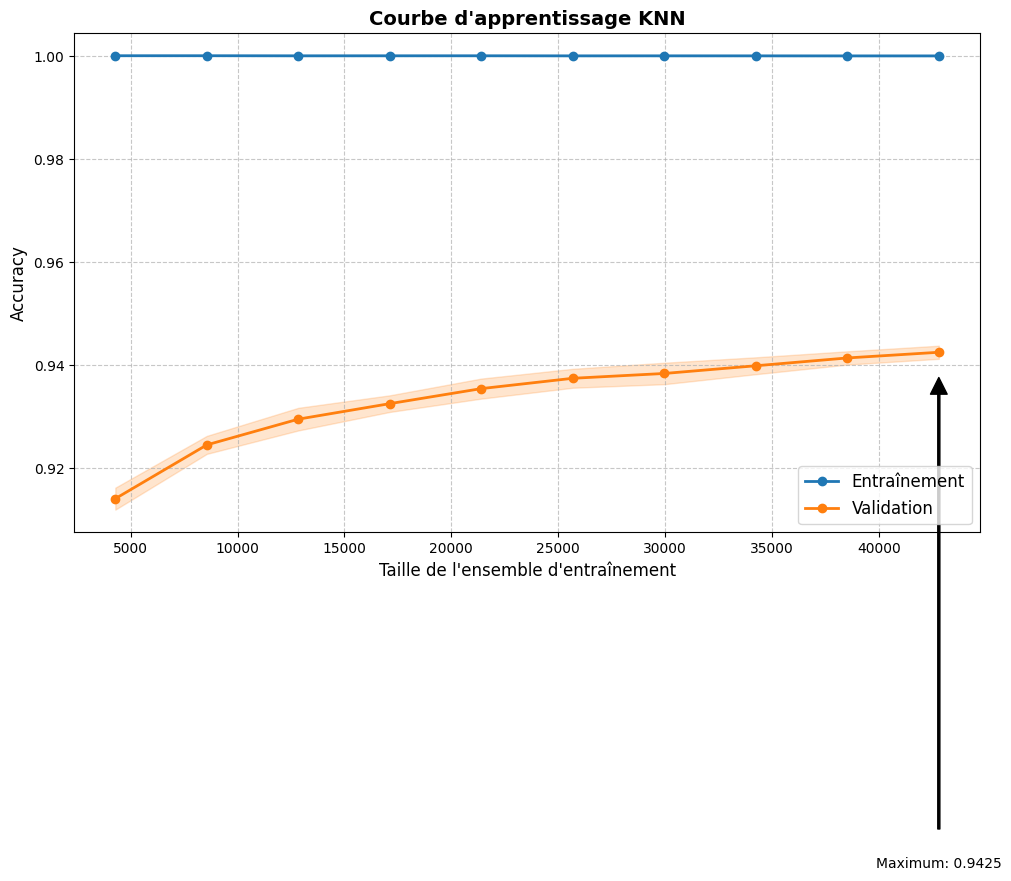

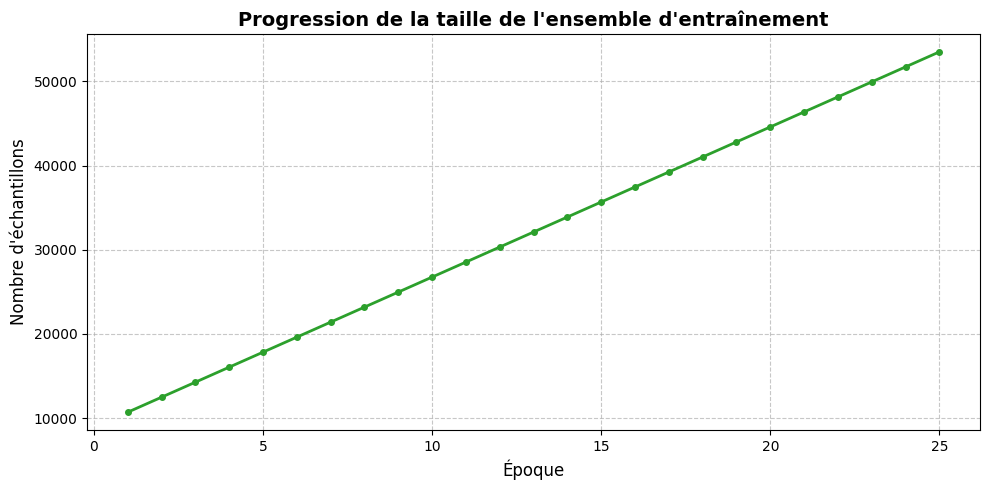

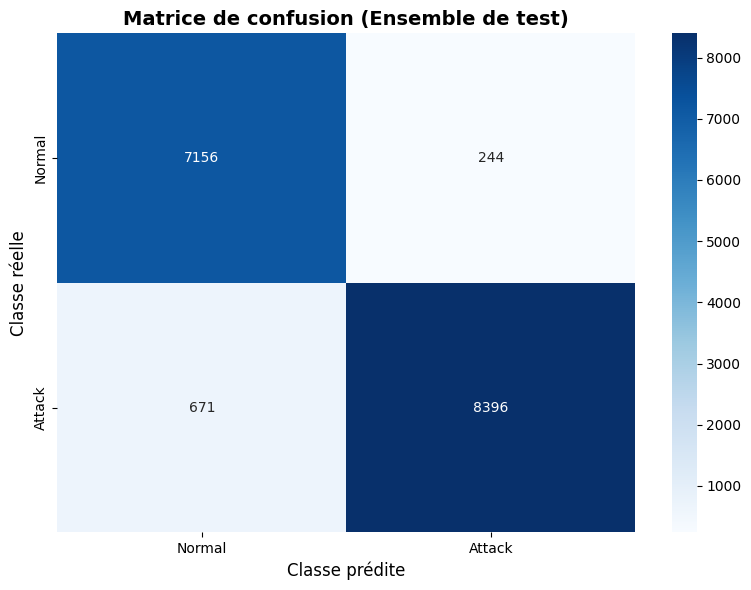

In [12]:

if __name__ == "__main__":
    # Point d'entr√©e du script
    print("=" * 80)
    print("Pipeline d'analyse et d'entra√Ænement KNN pour la d√©tection d'intrusion r√©seau")
    print("=" * 80)
    
    # V√©rifier si le fichier de donn√©es existe
    data_path = "UNSW_NB15_training-set.csv"
    if not os.path.exists(data_path):
        print(f"‚ö†Ô∏è Le fichier {data_path} n'existe pas. Veuillez sp√©cifier le chemin correct.")
        data_path = input("Chemin du fichier de donn√©es: ")
    
    # Ex√©cuter le pipeline principal
    main(data_path=data_path, n_epochs=25)

Pipeline d'analyse et d'entra√Ænement MLP pour la d√©tection d'intrusion r√©seau
Chargement et pr√©traitement des donn√©es depuis UNSW_NB15_training-set.csv...
Donn√©es charg√©es: 82332 lignes et 45 colonnes
Distribution des classes:
  - Classe 1: 45332 √©chantillons (55.06%)
  - Classe 0: 37000 √©chantillons (44.94%)
Encodage des 3 colonnes cat√©gorielles:
  - proto: 131 valeurs uniques
  - service: 13 valeurs uniques
  - state: 7 valeurs uniques
Dimensions des ensembles de donn√©es:
  Train: X=(53515, 42), y=(53515,)
  Validation: X=(12350, 42), y=(12350,)
  Test: X=(16467, 42), y=(16467,)
Distribution des classes dans les ensembles:
  Train: [24050 29465]
  Validation: [5550 6800]
  Test: [7400 9067]
Entra√Ænement progressif du MLP sur 25 √©poques...


Entra√Ænement: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25/25 [1:05:59<00:00, 158.39s/it, Train Acc=0.9794, Val Acc=0.9685, Train Size=53515]


‚úÖ Meilleur mod√®le MLP sauvegard√©

Temps total d'ex√©cution: 3963.24 secondes (66.05 minutes)

üìä R√©sum√© des performances:
Accuracy finale sur le test: 0.9653
Precision finale sur le test: 0.9776
Recall final sur le test: 0.9589
F1-Score final sur le test: 0.9682
Meilleurs hyperparam√®tres: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}


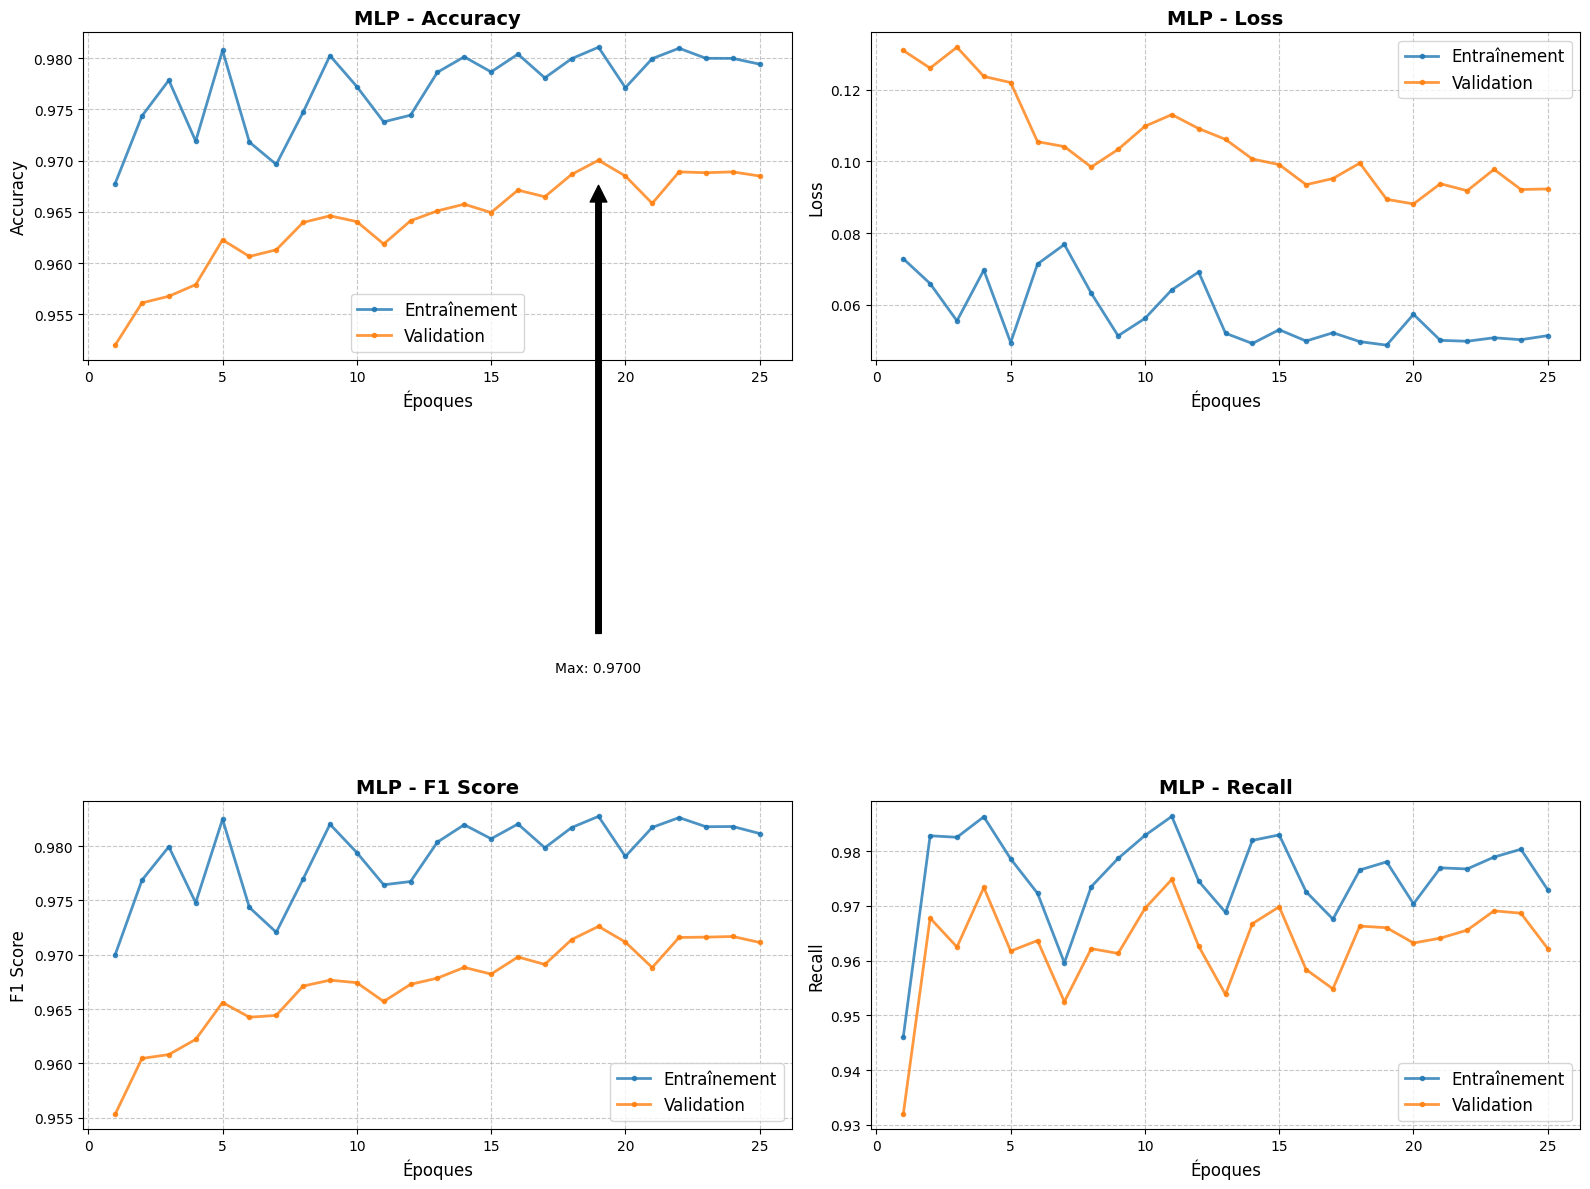

In [ ]:
# Cr√©ation des dossiers pour les r√©sultats
os.makedirs('figures/mlp', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [ ]:

def optimize_mlp_hyperparameters(X_train, y_train, X_val, y_val, cv=3):
    """
    Optimise les hyperparam√®tres du mod√®le MLP
    Args:
        X_train: Caract√©ristiques d'entra√Ænement
        y_train: √âtiquettes d'entra√Ænement
        X_val: Caract√©ristiques de validation
        y_val: √âtiquettes de validation
        cv: Nombre de plis pour la validation crois√©e
    Returns:
        Meilleurs hyperparam√®tres et score
    """
    print(f"Optimisation des hyperparam√®tres MLP...")
    param_dist = {
        'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive']
    }

    mlp = MLPClassifier(max_iter=200, early_stopping=True, random_state=42)
    grid_search = RandomizedSearchCV(
        mlp, param_distributions=param_dist, n_iter=15, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    print(f"Recherche par grille termin√©e en {search_time:.2f} secondes")

    val_score = accuracy_score(y_val, grid_search.predict(X_val))
    print(f"Meilleurs hyperparam√®tres: {grid_search.best_params_}")
    print(f"Score de validation crois√©e: {grid_search.best_score_:.4f}")
    print(f"Score sur l'ensemble de validation: {val_score:.4f}")

    return grid_search.best_params_, val_score



In [ ]:


def train_mlp_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=25):
    """
    Entra√Æne le mod√®le MLP de mani√®re progressive en augmentant la taille de l'ensemble d'entra√Ænement
    Args:
        X_train: Caract√©ristiques d'entra√Ænement
        y_train: √âtiquettes d'entra√Ænement
        X_val: Caract√©ristiques de validation
        y_val: √âtiquettes de validation
        X_test: Caract√©ristiques de test
        y_test: √âtiquettes de test
        best_params: Meilleurs hyperparam√®tres trouv√©s
        n_epochs: Nombre d'√©poques d'entra√Ænement
    Returns:
        Historique des m√©triques et meilleur mod√®le
    """
    print(f"Entra√Ænement progressif du MLP sur {n_epochs} √©poques...")

    # Convertir en tableaux NumPy pour √©viter les probl√®mes d'indexation
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
    if not isinstance(X_val, np.ndarray):
        X_val = np.array(X_val)
    if not isinstance(y_val, np.ndarray):
        y_val = np.array(y_val)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    # V√©rifier si l'entra√Ænement est possible
    if len(X_train) == 0 or len(y_train) == 0:
        raise ValueError("Ensembles d'entra√Ænement vides")
    if len(np.unique(y_train)) < 2:
        raise ValueError("L'ensemble d'entra√Ænement doit contenir au moins deux classes diff√©rentes")

    # M√©triques
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    epoch_train_sizes = []

    # Initialiser le mod√®le avec les meilleurs param√®tres
    model = MLPClassifier(**best_params, random_state=42)

    # Meilleur mod√®le
    best_model = None
    best_val_acc = 0

    # Valeurs pour l'augmentation progressive de la taille de l'ensemble d'entra√Ænement
    train_ratio_start = 0.2  # Commence avec 20% des donn√©es
    train_ratio_end = 1.0    # Termine avec 100% des donn√©es

    # Assurer une r√©partition √©quilibr√©e des classes lors de l'√©chantillonnage
    class_indices = {}
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        class_indices[cls] = np.where(y_train == cls)[0]

    with tqdm(total=n_epochs, desc="Entra√Ænement") as pbar:
        for epoch in range(n_epochs):
            try:
                # Augmentation progressive de la taille de l'entra√Ænement
                train_ratio = train_ratio_start + (train_ratio_end - train_ratio_start) * (epoch / max(1, n_epochs-1))
                indices = []
                for cls in unique_classes:
                    n_samples = int(len(class_indices[cls]) * train_ratio)
                    cls_sample = np.random.choice(class_indices[cls], n_samples, replace=False)
                    indices.extend(cls_sample)
                np.random.shuffle(indices)
                train_size = len(indices)
                epoch_train_sizes.append(train_size)
                # Extraire les donn√©es d'entra√Ænement pour cette √©poque
                X_epoch = X_train[indices]
                y_epoch = y_train[indices]

                # Cr√©er et entra√Æner le mod√®le avec les meilleurs hyperparam√®tres
                model.fit(X_epoch, y_epoch)

                # √âvaluations
                train_pred = model.predict(X_epoch)
                val_pred = model.predict(X_val)

                train_accuracies.append(accuracy_score(y_epoch, train_pred))
                val_accuracies.append(accuracy_score(y_val, val_pred))
                train_precisions.append(precision_score(y_epoch, train_pred, zero_division=0))
                val_precisions.append(precision_score(y_val, val_pred, zero_division=0))
                train_recalls.append(recall_score(y_epoch, train_pred, zero_division=0))
                val_recalls.append(recall_score(y_val, val_pred, zero_division=0))
                train_f1s.append(f1_score(y_epoch, train_pred, zero_division=0))
                val_f1s.append(f1_score(y_val, val_pred, zero_division=0))

                # Calcul des pertes (log loss) si predict_proba est disponible
                if hasattr(model, 'predict_proba'):
                    try:
                        train_probs = model.predict_proba(X_epoch)
                        val_probs = model.predict_proba(X_val)
                        # V√©rifier la validit√© des probabilit√©s
                        if not np.any(np.isnan(train_probs)) and not np.any(np.isnan(val_probs)):
                            train_loss = log_loss(y_epoch, train_probs)
                            val_loss = log_loss(y_val, val_probs)
                        else:
                            train_loss = -np.log(max(0.001, train_accuracies[-1]))
                            val_loss = -np.log(max(0.001, val_accuracies[-1]))
                    except Exception:
                        # En cas d'erreur, utiliser une approximation
                        train_loss = -np.log(max(0.001, train_accuracies[-1]))
                        val_loss = -np.log(max(0.001, val_accuracies[-1]))
                else:
                    # Si predict_proba n'est pas disponible, simuler une relation inverse avec l'accuracy
                    train_loss = -np.log(max(0.001, train_accuracies[-1]))
                    val_loss = -np.log(max(0.001, val_accuracies[-1]))

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                pbar.update(1)
                pbar.set_postfix({
                    'Train Acc': f'{train_accuracies[-1]:.4f}',
                    'Val Acc': f'{val_accuracies[-1]:.4f}',
                    'Train Size': train_size
                })

                # Suivre le meilleur mod√®le
                if val_accuracies[-1] > best_val_acc:
                    best_val_acc = val_accuracies[-1]
                    best_model = model

            except Exception as e:
                print(f"Erreur √† l'√©poque {epoch+1}: {str(e)}")
                continue

    # Si aucun mod√®le valide n'a √©t√© trouv√©, utiliser un mod√®le par d√©faut
    if best_model is None:
        print("Aucun mod√®le valide trouv√© pendant l'entra√Ænement. Cr√©ation d'un mod√®le par d√©faut.")
        best_model = MLPClassifier(**best_params, random_state=42)
        best_model.fit(X_train, y_train)

     
    try:
        plot_training_metrics(train_accuracies, val_accuracies, train_losses, val_losses, 
                             train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
                             algorithm_name="MLP", output_dir="figures/mlp")
    except Exception as e:
        print(f"Erreur lors de la cr√©ation des graphiques: {str(e)}")
    # √âvaluation finale du meilleur mod√®le sur l'ensemble de test
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, test_pred)


    # Sauvegarder
    joblib.dump(best_model, "models/mlp_best.pkl")
    print("‚úÖ Meilleur mod√®le MLP sauvegard√©")

    return {
        'model': best_model,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': conf_matrix
    }



In [ ]:
def main():
    data_path = "UNSW_NB15_training-set.csv"
    print("=" * 80)
    print("Pipeline d'analyse et d'entra√Ænement MLP pour la d√©tection d'intrusion r√©seau")
    print("=" * 80)

    start_time = time.time()

    X_train, X_val, X_test, y_train, y_val, y_test, scaler, encoders = load_and_preprocess_data(data_path)
    joblib.dump(scaler, "models/scaler_mlp.pkl")
    joblib.dump(encoders, "models/label_encoders_mlp.pkl")

    # Optimiser les hyperparam√®tres
    # best_params, val_score = optimize_mlp_hyperparameters(X_train, y_train, X_val, y_val)
    best_params={'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}
    # Tracer la courbe d'apprentissage pour √©valuer l'impact de la taille de l'ensemble d'entra√Ænement
    # model = MLPClassifier(**best_params)
    # plot_learning_curve(model, X_train, y_train)
    # Entra√Ænement progressif
    results = train_mlp_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=25)

    elapsed_time = time.time() - start_time
    print(f"\nTemps total d'ex√©cution: {elapsed_time:.2f} secondes ({elapsed_time / 60:.2f} minutes)")
    print("\nüìä R√©sum√© des performances:")
    print(f"Accuracy finale sur le test: {results['test_accuracy']:.4f}")
    print(f"Precision finale sur le test: {results['test_precision']:.4f}")
    print(f"Recall final sur le test: {results['test_recall']:.4f}")
    print(f"F1-Score final sur le test: {results['test_f1']:.4f}")
    print(f"Meilleurs hyperparam√®tres: {best_params}")


if __name__ == "__main__":
    main()

In [ ]:
    # Meilleurs hyperparam√®tres: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'solver': 'adam'}

Pipeline d'analyse et d'entra√Ænement XGBoost pour la d√©tection d'intrusion r√©seau
Chargement et pr√©traitement des donn√©es depuis UNSW_NB15_training-set.csv...
Donn√©es charg√©es: 82332 lignes et 45 colonnes
Distribution des classes:
  - Classe 1: 45332 √©chantillons (55.06%)
  - Classe 0: 37000 √©chantillons (44.94%)
Encodage des 3 colonnes cat√©gorielles:
  - proto: 131 valeurs uniques
  - service: 13 valeurs uniques
  - state: 7 valeurs uniques
Dimensions des ensembles de donn√©es:
  Train: X=(53515, 42), y=(53515,)
  Validation: X=(12350, 42), y=(12350,)
  Test: X=(16467, 42), y=(16467,)
Distribution des classes dans les ensembles:
  Train: [24050 29465]
  Validation: [5550 6800]
  Test: [7400 9067]
Optimisation des hyperparam√®tres XGBoost...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Recherche par grille termin√©e en 30.87 secondes
Meilleurs hyperparam√®tres: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 150, 'max_depth': 7, 'learning

Entra√Ænement: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 25/25 [00:33<00:00,  1.33s/it, Train Acc=0.9935, Val Acc=0.9823, Train Size=53515]


‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/xgb\xgboost_accuracy.png
‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/xgb\xgboost_loss.png
‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/xgb\xgboost_f1_score.png
‚úÖ M√©triques d'entra√Ænement enregistr√©es dans figures/xgb\xgboost_recall.png
‚úÖ Meilleur mod√®le XGBoost sauvegard√©

Temps total d'ex√©cution: 93.31 secondes (1.56 minutes)

üìä R√©sum√© des performances:
Accuracy finale sur le test: 0.9786
Precision finale sur le test: 0.9866
Recall final sur le test: 0.9744
F1-Score final sur le test: 0.9805
Meilleurs hyperparam√®tres: {'subsample': 1.0, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
üîç Analyse de la matrice de confusion:
 - Vrais N√©gatifs (TN): 7280 (44.21%)
 - Faux Positifs (FP): 120 (0.73%)
 - Faux N√©gatifs (FN): 232 (1.41%)
 - Vrais Positifs (TP): 8835 (53.65%)
 - Taux de faux positifs: 1.62%
 - 

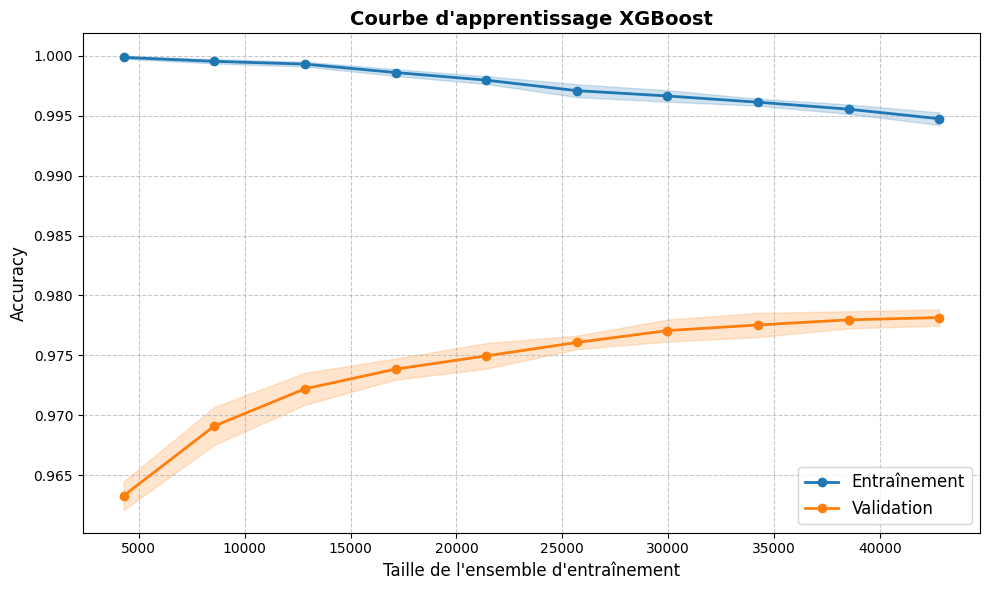

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.exceptions import ConvergenceWarning
import time
from tqdm import tqdm
import warnings

# Supprimer les avertissements non n√©cessaires
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Cr√©ation des dossiers pour les r√©sultats
os.makedirs('figures/xgb', exist_ok=True)
os.makedirs('models', exist_ok=True)


def optimize_xgb_hyperparameters(X_train, y_train, X_val, y_val, cv=3):
    """
    Optimise les hyperparam√®tres du mod√®le XGBoost
    Args:
        X_train: Caract√©ristiques d'entra√Ænement
        y_train: √âtiquettes d'entra√Ænement
        X_val: Caract√©ristiques de validation
        y_val: √âtiquettes de validation
        cv: Nombre de plis pour la validation crois√©e
    Returns:
        Meilleurs hyperparam√®tres et score
    """
    print(f"Optimisation des hyperparam√®tres XGBoost...")
    param_dist = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.2],
        'reg_lambda': [1, 1.5, 2]
    }

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    grid_search = RandomizedSearchCV(
        xgb, param_distributions=param_dist, n_iter=15, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
    )

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    print(f"Recherche par grille termin√©e en {search_time:.2f} secondes")

    val_score = accuracy_score(y_val, grid_search.predict(X_val))
    print(f"Meilleurs hyperparam√®tres: {grid_search.best_params_}")
    print(f"Score de validation crois√©e: {grid_search.best_score_:.4f}")
    print(f"Score sur l'ensemble de validation: {val_score:.4f}")

    return grid_search.best_params_, val_score


def train_xgb_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=25):
    """
    Entra√Æne le mod√®le XGBoost de mani√®re progressive en augmentant la taille de l'ensemble d'entra√Ænement
    Args:
        X_train: Caract√©ristiques d'entra√Ænement
        y_train: √âtiquettes d'entra√Ænement
        X_val: Caract√©ristiques de validation
        y_val: √âtiquettes de validation
        X_test: Caract√©ristiques de test
        y_test: √âtiquettes de test
        best_params: Meilleurs hyperparam√®tres trouv√©s
        n_epochs: Nombre d'√©poques d'entra√Ænement
    Returns:
        Historique des m√©triques et meilleur mod√®le
    """
    print(f"Entra√Ænement progressif du XGBoost sur {n_epochs} √©poques...")

    # M√©triques
    train_accuracies = []
    val_accuracies = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []
    train_losses = []
    val_losses = []
    epoch_train_sizes = []
     # Convertir en tableaux NumPy pour √©viter les probl√®mes d'indexation
    if not isinstance(X_train, np.ndarray):
        X_train = np.array(X_train)
    if not isinstance(y_train, np.ndarray):
        y_train = np.array(y_train)
    if not isinstance(X_val, np.ndarray):
        X_val = np.array(X_val)
    if not isinstance(y_val, np.ndarray):
        y_val = np.array(y_val)
    if not isinstance(X_test, np.ndarray):
        X_test = np.array(X_test)
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    # Initialiser le mod√®le avec les meilleurs param√®tres
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    # Meilleur mod√®le
    best_model = None
    best_val_acc = 0

    # Valeurs pour l'augmentation progressive de la taille de l'ensemble d'entra√Ænement
    train_ratio_start = 0.2  # Commence avec 20% des donn√©es
    train_ratio_end = 1.0    # Termine avec 100% des donn√©es

    # Assurer une r√©partition √©quilibr√©e des classes lors de l'√©chantillonnage
    class_indices = {}
    unique_classes = np.unique(y_train)
    for cls in unique_classes:
        class_indices[cls] = np.where(y_train == cls)[0]

    with tqdm(total=n_epochs, desc="Entra√Ænement") as pbar:
        for epoch in range(n_epochs):
            try:
                # Augmentation progressive de la taille de l'entra√Ænement
                train_ratio = train_ratio_start + (train_ratio_end - train_ratio_start) * (epoch / max(1, n_epochs-1))
                indices = []
                for cls in unique_classes:
                    n_samples = int(len(class_indices[cls]) * train_ratio)
                    cls_sample = np.random.choice(class_indices[cls], n_samples, replace=False)
                    indices.extend(cls_sample)
                np.random.shuffle(indices)
                train_size = len(indices)
                epoch_train_sizes.append(train_size)
                # Extraire les donn√©es d'entra√Ænement pour cette √©poque
                X_epoch = X_train[indices]
                y_epoch = y_train[indices]

                # Cr√©er et entra√Æner le mod√®le avec les meilleurs hyperparam√®tres
                model.fit(X_epoch, y_epoch)

                # √âvaluations
                train_pred = model.predict(X_epoch)
                val_pred = model.predict(X_val)

                train_accuracies.append(accuracy_score(y_epoch, train_pred))
                val_accuracies.append(accuracy_score(y_val, val_pred))
                train_precisions.append(precision_score(y_epoch, train_pred, zero_division=0))
                val_precisions.append(precision_score(y_val, val_pred, zero_division=0))
                train_recalls.append(recall_score(y_epoch, train_pred, zero_division=0))
                val_recalls.append(recall_score(y_val, val_pred, zero_division=0))
                train_f1s.append(f1_score(y_epoch, train_pred, zero_division=0))
                val_f1s.append(f1_score(y_val, val_pred, zero_division=0))

                # Calcul des pertes (log loss) si predict_proba est disponible
                if hasattr(model, 'predict_proba'):
                    try:
                        train_probs = model.predict_proba(X_epoch)
                        val_probs = model.predict_proba(X_val)
                        # V√©rifier la validit√© des probabilit√©s
                        if not np.any(np.isnan(train_probs)) and not np.any(np.isnan(val_probs)):
                            train_loss = log_loss(y_epoch, train_probs)
                            val_loss = log_loss(y_val, val_probs)
                        else:
                            train_loss = -np.log(max(0.001, train_accuracies[-1]))
                            val_loss = -np.log(max(0.001, val_accuracies[-1]))
                    except Exception:
                        # En cas d'erreur, utiliser une approximation
                        train_loss = -np.log(max(0.001, train_accuracies[-1]))
                        val_loss = -np.log(max(0.001, val_accuracies[-1]))
                else:
                    # Si predict_proba n'est pas disponible, simuler une relation inverse avec l'accuracy
                    train_loss = -np.log(max(0.001, train_accuracies[-1]))
                    val_loss = -np.log(max(0.001, val_accuracies[-1]))

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                pbar.update(1)
                pbar.set_postfix({
                    'Train Acc': f'{train_accuracies[-1]:.4f}',
                    'Val Acc': f'{val_accuracies[-1]:.4f}',
                    'Train Size': train_size
                })

                # Suivre le meilleur mod√®le
                if val_accuracies[-1] > best_val_acc:
                    best_val_acc = val_accuracies[-1]
                    best_model = model

            except Exception as e:
                print(f"Erreur √† l'√©poque {epoch+1}: {str(e)}")
                continue

    # Si aucun mod√®le valide n'a √©t√© trouv√©, utiliser un mod√®le par d√©faut
    if best_model is None:
        print("Aucun mod√®le valide trouv√© pendant l'entra√Ænement. Cr√©ation d'un mod√®le par d√©faut.")
        best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        best_model.fit(X_train, y_train)

    try:
        plot_training_metrics(
            train_accuracies, val_accuracies, train_losses, val_losses, 
            train_f1s, val_f1s, train_recalls, val_recalls, n_epochs,
            algorithm_name="XGBoost", output_dir="figures/xgb"
        )
    except Exception as e:
        print(f"Erreur lors de la cr√©ation des graphiques: {str(e)}")

    # √âvaluation finale du meilleur mod√®le sur l'ensemble de test
    test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, test_pred)

    # Sauvegarder
    joblib.dump(best_model, "models/xgb_best.pkl")
    print("‚úÖ Meilleur mod√®le XGBoost sauvegard√©")

    return {
        'model': best_model,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': conf_matrix
    }


def plot_training_size(epoch_train_sizes, n_epochs):
    """
    Trace la progression de la taille de l'ensemble d'entra√Ænement
    Args:
        epoch_train_sizes: Liste des tailles d'entra√Ænement √† chaque √©poque
        n_epochs: Nombre d'√©poques
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs+1), epoch_train_sizes, '-o', linewidth=2, markersize=4, color='#2ca02c')
    plt.title('Progression de la taille de l\'ensemble d\'entra√Ænement', fontsize=14, fontweight='bold')
    plt.xlabel('√âpoque', fontsize=12)
    plt.ylabel('Nombre d\'√©chantillons', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('figures/xgb/xgb_training_size.png', dpi=300)
    plt.close()


def plot_confusion_matrix(conf_matrix):
    """
    Trace la matrice de confusion
    Args:
        conf_matrix: Matrice de confusion
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title('Matrice de confusion (Ensemble de test)', fontsize=14, fontweight='bold')
    plt.xlabel('Classe pr√©dite', fontsize=12)
    plt.ylabel('Classe r√©elle', fontsize=12)
    plt.tight_layout()
    plt.savefig('figures/xgb/xgb_confusion_matrix.png', dpi=300)
    plt.close()


def main(data_path="UNSW_NB15_training-set.csv", test_size=0.2, val_size=0.15, n_epochs=25, random_state=42):
    """
    Fonction principale qui ex√©cute tout le pipeline
    """
    print("=" * 80)
    print("Pipeline d'analyse et d'entra√Ænement XGBoost pour la d√©tection d'intrusion r√©seau")
    print("=" * 80)

    start_time = time.time()

    X_train, X_val, X_test, y_train, y_val, y_test, scaler, encoders = load_and_preprocess_data(
        filepath=data_path, test_size=test_size, val_size=val_size, random_state=random_state
    )
    joblib.dump(scaler, "models/scaler_xgb.pkl")
    joblib.dump(encoders, "models/label_encoders_xgb.pkl")

    # Optimiser les hyperparam√®tres
    best_params, val_score = optimize_xgb_hyperparameters(X_train, y_train, X_val, y_val, cv=3)
    # Tracer la courbe d'apprentissage pour √©valuer l'impact de la taille de l'ensemble d'entra√Ænement
    model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    plot_learning_curve(model, X_train, y_train)
    # Entra√Ænement progressif
    results = train_xgb_progressive(X_train, y_train, X_val, y_val, X_test, y_test, best_params, n_epochs=n_epochs)

    elapsed_time = time.time() - start_time
    print(f"\nTemps total d'ex√©cution: {elapsed_time:.2f} secondes ({elapsed_time / 60:.2f} minutes)")
    print("\nüìä R√©sum√© des performances:")
    print(f"Accuracy finale sur le test: {results['test_accuracy']:.4f}")
    print(f"Precision finale sur le test: {results['test_precision']:.4f}")
    print(f"Recall final sur le test: {results['test_recall']:.4f}")
    print(f"F1-Score final sur le test: {results['test_f1']:.4f}")
    print(f"Meilleurs hyperparam√®tres: {best_params}")

    # √âvaluation finale du mod√®le
    print("üîç Analyse de la matrice de confusion:")
    conf_matrix = results['confusion_matrix']
    tn, fp, fn, tp = conf_matrix.ravel()
    total = tn + fp + fn + tp
    print(f" - Vrais N√©gatifs (TN): {tn} ({tn/total*100:.2f}%)")
    print(f" - Faux Positifs (FP): {fp} ({fp/total*100:.2f}%)")
    print(f" - Faux N√©gatifs (FN): {fn} ({fn/total*100:.2f}%)")
    print(f" - Vrais Positifs (TP): {tp} ({tp/total*100:.2f}%)")
    print(f" - Taux de faux positifs: {fp/(fp+tn)*100:.2f}%")
    print(f" - Taux de faux n√©gatifs: {fn/(fn+tp)*100:.2f}%")


    # Tracer la matrice de confusion pour le meilleur mod√®le
    plot_confusion_matrix(conf_matrix)


if __name__ == "__main__":
    main()